In [1]:
import sys
sys.path.append('../')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pickle
import pandas as pd
from itertools import product as prod
import proplot as pplt
from collections import defaultdict
from scipy.special import expit
from tqdm import tqdm
import itertools as it
import matplotlib.patches as mpatches, matplotlib.lines as mlines
import seaborn as sns
from torch import nn
import argparse
import scipy
from scipy.sparse import linalg as splinalg
import scipy.sparse as sparse
import sys
import utils
from torch.utils.data import Dataset, DataLoader
import yaml
import os
from models import UNetEncoder, Decoder
import torch
import torchvision.transforms.functional as vF
import seaborn as sns

nd, nr, nc = 5, 128, 256
ksize = 13
dev = "cuda" if torch.cuda.is_available() else "cpu"
np.random.seed(110104)
plt.rc("text", usetex=True)

d:\Github\weather2vec\conda-env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dirs = [
    "../results/unsupervised-narr/r9_w2vec",
    "../results/unsupervised-narr/r3_w2vec",
    "../results/unsupervised-narr/r9_nbrs",
    "../results/unsupervised-narr/r3_nbrs",
    "../results/unsupervised-narr/r3_local",
]

def model_from_dir(s: str):
    if s.endswith("_w2vec"):
        return "w2vec"
    elif s.endswith("_nbrs"):
        return "avs"
    elif s.endswith("_local"):
        return "local"

def radius_from_dir(s: str):
    return int(s.split("/")[-1].split("_")[0].replace("r", ""))


In [4]:
class NARRData(Dataset):
    def __init__(self, path: str, radius: int, nbr_av_size: int = 0):
        super().__init__()
        assert radius >= 0
        self.nbr_av_size = nbr_av_size
        self.radius = radius

        # load data
        C, _, *_ = utils.load_training_data(path, standardize_weather=True)
        self.C = torch.FloatTensor(C)
        self.Ctgts = self.C.clone()

        # compute neighbor averages
        if nbr_av_size > 0:
            self.C = utils.nbrs_avg(self.C, nbr_av_size)

    def __len__(self):
        return self.C.shape[0]

    def rand_offset_target(self, tgt, ord=2):
        radius = self.radius
        if radius == 0:
            offset = [0, 0]
        else:
            while True:
                offset = np.random.randint(-radius, radius + 1, size=2)
                if np.linalg.norm(offset, ord=ord) <= radius:
                    offset = list(offset)
                    break
        kws = dict(translate=offset, angle=0.0, scale=1.0, shear=0.0)
        shifted_tgt = vF.affine(tgt, **kws)
        mask = vF.affine(torch.ones_like(tgt), fill=0.0, **kws)
        offset = torch.FloatTensor(offset)
        return offset, shifted_tgt, mask

    def __getitem__(self, index):
        Ct = self.C[index]
        offset, Ct1, Mt = self.rand_offset_target(self.Ctgts[index])
        return Ct, Ct1, offset, Mt

In [5]:
D = dict()
for datadir in dirs:
    radius = radius_from_dir(datadir)
    bench = model_from_dir(datadir)
    args = argparse.Namespace()
    with open(os.path.join(datadir, "args.yaml"), "r") as io:
        for k, v in yaml.load(io, Loader=yaml.FullLoader).items():
            setattr(args, k, v)
            if k == "nbrs_av":
                setattr(args, "av_nbrs", v)
            elif k == "av_nbrs":
                setattr(args, "nbrs_av", v)
    bn_type ="frn" if not hasattr(args, "bn_type") else args.bn_type
    mkw = dict(
        n_hidden=args.nhidden,
        depth=args.depth,
        num_res=args.nres,
        ksize=args.ksize,
        groups=args.groups,
        batchnorm=True,
        batchnorm_type=bn_type,
    )
    print(vars(args))
    dkw = dict(batchnorm=True, offset=True, batchnorm_type=bn_type)
    dev = "cuda" if torch.cuda.is_available() else "cpu"
    if not args.local and args.nbrs_av == 0:
        enc = UNetEncoder(nd, args.nhidden, **mkw).to(dev)
        dec = Decoder(args.nhidden, nd, args.nhidden, **dkw).to(dev)
    else:
        enc = nn.Identity()
        dec = Decoder(nd, nd, args.nhidden, **dkw).to(dev)
    mod = nn.ModuleDict({"enc": enc, "dec": dec})
    objs = dict(
        mod=mod,
        args=args,
        radius=radius,
        bench=bench,
        nbrs_av=args.nbrs_av,
        local=args.local,
    )
    mod.eval()
    for p in mod.parameters():
        p.requires_grad = False
    mod = mod.to(dev)
    D[datadir] = objs

{'batchsize': 4, 'bntype': 'frn', 'datapath': 'data/training_data.pkl', 'depth': 3, 'depthwise': False, 'device': 0, 'epochs': 300, 'groups': 1, 'ksize': 3, 'local': False, 'lr0': 0.03, 'lr1': 5e-05, 'nbrs_av': 0, 'av_nbrs': 0, 'nhidden': 32, 'nres': 0, 'nworkers': 0, 'odir': 'results/unsupervised-narr\\r9_w2vec', 'radius': 9, 'seed': 1234, 'wdecay': 0.0}
{'batchsize': 4, 'bntype': 'frn', 'datapath': 'data/training_data.pkl', 'depth': 3, 'depthwise': False, 'device': 0, 'epochs': 300, 'groups': 1, 'ksize': 3, 'local': False, 'lr0': 0.03, 'lr1': 5e-05, 'nbrs_av': 0, 'av_nbrs': 0, 'nhidden': 32, 'nres': 0, 'nworkers': 0, 'odir': 'results/unsupervised-narr\\r3_w2vec', 'radius': 3, 'seed': 1234, 'wdecay': 0.0}
{'batchsize': 4, 'datapath': 'E:/power_plant_data/grid_training_data_ozone_and_so4.pkl', 'depth': 2, 'depthwise': False, 'device': 0, 'epochs': 300, 'groups': 1, 'ksize': 3, 'local': False, 'lr0': 0.01, 'lr1': 0.0001, 'nbrs_av': 9, 'av_nbrs': 9, 'nhidden': 32, 'nres': 0, 'nworkers': 

In [6]:
path = "../data/training_data.pkl"
dataset = NARRData(path, 10)
loader = DataLoader(dataset, batch_size=8, shuffle=True)

epochs = 20
losses = defaultdict(list)
for e in tqdm(range(epochs)):
    for sample in loader:
        C, C1, offsets, M = [x.to(dev) for x in sample]
        for k, v in D.items():
            mod = v["mod"]
            mod.load_state_dict(torch.load(os.path.join(k, "model.pt")))
            
            if v["nbrs_av"] > 0:
                C1hat = utils.nbrs_avg(C, v["nbrs_av"])
            elif v["local"]:
                C1hat = C
            else:
                Z = mod["enc"](C)
                C1hat = mod["dec"](Z, offsets)
            loss_t = (M * (C1hat - C1)).pow(2).sum((1, 2, 3))
            loss = loss_t.mean()
            ss_t = (M * C1).pow(2).sum((1, 2, 3))
            for (o1, o2), l, s in zip(offsets, loss_t, ss_t):
                row = dict(
                    bench=v["bench"],
                    radius=v["radius"],
                    dr=int(o1),
                    dc=int(o2),
                    dist=np.sqrt(int(o1)**2 + int(o2)**2),
                    sse=l.item(),
                    ss=s.item()
                )
                losses[k].append(row)

100%|██████████| 20/20 [03:15<00:00,  9.77s/it]


In [7]:
dfs = dict()
for k, v in losses.items():
    short_name = k.split("/")[-1]
    df = pd.DataFrame(v)
    df["dist"] = np.round(df.dist)
    df = df.groupby("dist").sum().reset_index().sort_values("dist")
    df["r2"] = 1.0 - df.sse / df.ss
    dfs[short_name] = df

In [8]:
names = list(dfs.keys())
arr = np.array([dfs[n].r2.values for n in names]).T
arr.shape

(11, 5)

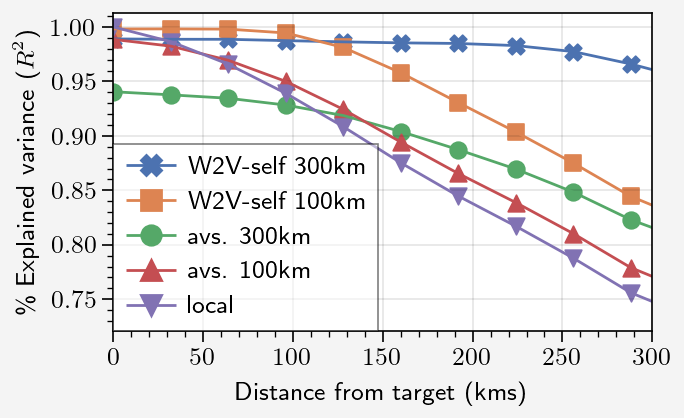

In [9]:
fig, ax = pplt.subplots([1], figsize=(3.42, 2.09))
kms = np.arange(arr.shape[0]) * 32
markers = ["X", "s", "o", "^", "v"]
colors = sns.color_palette("deep", n_colors=5)
for i, n in enumerate(names[:5]):
    ax.plot(kms, arr[:, i], lw=1, c=colors[i])
    ax.scatter(kms, arr[:, i], marker=markers[i], color=colors[i])
# ax.legend(loc="ll", ncol=1)
ax.set_xlabel("Distance from target (kms)")
ax.set_ylabel("\\% Explained variance ($R^2$)")

pretty_names = [
    "W2V-self 300km", "W2V-self 100km",
    "avs. 300km", "avs. 100km", "local"
]
plt.xlim(0, 300)

patches = [
    mlines.Line2D([], [], color=colors[i], label=pretty_names[i], marker=markers[i], markersize=7, linewidth=1)
    for i in range(5)
]
ax.legend(handles=patches, loc="ll", ncol=1, framealpha=0.5, fontsize=8)
plt.savefig("../figures/explained_variance.png", bbox_inches="tight")